# Visualization Utils - Presentation

In [1]:
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
import pandas.util.testing as tm

import torch
import scipy.sparse
from torch import Tensor
from torch.utils.dlpack import to_dlpack, from_dlpack

import torch_geometric.data
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.utils import k_hop_subgraph, from_scipy_sparse_matrix, to_scipy_sparse_matrix
from torch_geometric.utils import is_undirected, to_undirected
from scipy.sparse import csr_matrix

from pgmpy.estimators.CITests import chi_square
from scipy.special import softmax

from sklearn.model_selection import train_test_split

import torch.nn.functional as F
from torch.nn import BatchNorm1d
from torch_geometric.nn import GCNConv

import sys, os
sys.path.insert(0, '/cluster/home/kamara/Explain')
sys.path.insert(0, '/cluster/home/kamara/Explain/code')

import json
import pickle
import time
from datetime import datetime
import argparse
import random
import itertools

from dataset import *
from evaluate import *
from explainer import *
from dataset.syn_utils.gengraph import gen_ba_house
#from gnn import GcnEncoderNode, train, gnn_scores, get_labels
from utils.gen_utils import get_subgraph, from_edge_index_to_adj, from_adj_to_edge_index
from utils.io_utils import check_dir
from utils.parser_utils import arg_parse
from evaluate.mask_utils import mask_to_shape


/tmp/ipykernel_26101/4124416719.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
print(plt.get_backend())

module://matplotlib_inline.backend_inline


In [3]:
import seaborn as sns

In [5]:

def _fruchterman_reingold(
    A, k=None, pos=None, fixed=None, iterations=50, threshold=1e-4, dim=2, seed=None
):
    # Position nodes in adjacency matrix A using Fruchterman-Reingold
    # Entry point for NetworkX graph is fruchterman_reingold_layout()
    import numpy as np

    try:
        nnodes, _ = A.shape
    except AttributeError as e:
        msg = "fruchterman_reingold() takes an adjacency matrix as input"
        raise nx.NetworkXError(msg) from e

    if pos is None:
        # random initial positions
        pos = np.asarray(seed.rand(nnodes, dim), dtype=A.dtype)
    else:
        # make sure positions are of same type as matrix
        pos = pos.astype(A.dtype)

    # optimal distance between nodes
    if k is None:
        k = np.sqrt(1.0 / nnodes)
    # the initial "temperature"  is about .1 of domain area (=1x1)
    # this is the largest step allowed in the dynamics.
    # We need to calculate this in case our fixed positions force our domain
    # to be much bigger than 1x1
    t = max(max(pos.T[0]) - min(pos.T[0]), max(pos.T[1]) - min(pos.T[1])) * 0.1
    # simple cooling scheme.
    # linearly step down by dt on each iteration so last iteration is size dt.
    dt = t / float(iterations + 1)
    delta = np.zeros((pos.shape[0], pos.shape[0], pos.shape[1]), dtype=A.dtype)
    # the inscrutable (but fast) version
    # this is still O(V^2)
    # could use multilevel methods to speed this up significantly
    for iteration in range(iterations):
        # matrix of difference between points
        delta = pos[:, np.newaxis, :] - pos[np.newaxis, :, :]
        # distance between points
        distance = np.linalg.norm(delta, axis=-1)
        # enforce minimum distance of 0.01
        np.clip(distance, 0.01, None, out=distance)
        # displacement "force"
        displacement = np.einsum(
            "ijk,ij->ik", delta, (k * k / distance ** 2 - A * distance / k)
        )
        # ADD THIS LINE - prevent things from flying off into infinity if not connected
        displacement = displacement - pos / ( k * np.sqrt(nnodes))
        # update positions
        length = np.linalg.norm(displacement, axis=-1)
        length = np.where(length < 0.01, 0.1, length)
        delta_pos = np.einsum("ij,i->ij", displacement, t / length)
        if fixed is not None:
            # don't change positions of fixed nodes
            delta_pos[fixed] = 0.0
        pos += delta_pos
        # cool temperature
        t -= dt
        err = np.linalg.norm(delta_pos) / nnodes
        if err < threshold:
            break
    return pos

In [23]:
dict_color_labels = {0: 'orange', 1: 'green', 2: 'green', 3:'green'}
node_labels = [dict_color_labels[l] for l in labels]

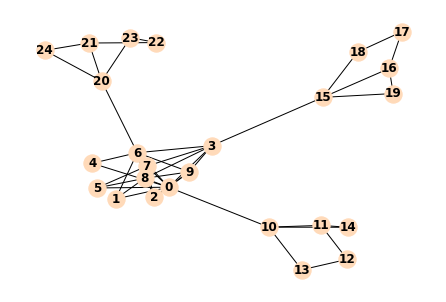

In [20]:
G, labels, _ = gen_ba_house(nb_shapes=3, width_basis=10, feature_generator=None, m=5)
pos = nx.spring_layout(G, k=0.15, iterations=20)
nx.draw(G, pos, node_color="peachpuff", with_labels=True, font_weight='bold')

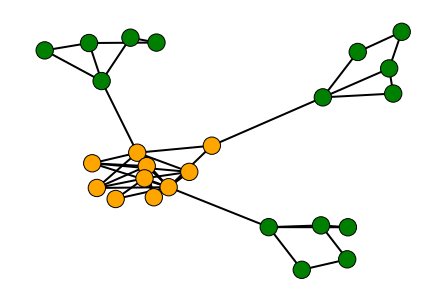

In [22]:
G, labels, _ = gen_ba_house(nb_shapes=3, width_basis=10, feature_generator=None, m=5)
nx.draw(G, pos, node_color=node_labels, edgecolors='black', width=2)

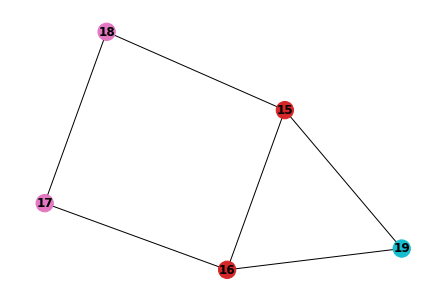

In [24]:
res = np.array([15, 16, 17, 18, 19])
k = G.subgraph(res)
nx.draw(k, cmap=plt.get_cmap('tab10'), node_color=np.take(labels, res), with_labels=True, font_weight='bold', vmin=0, vmax=3)

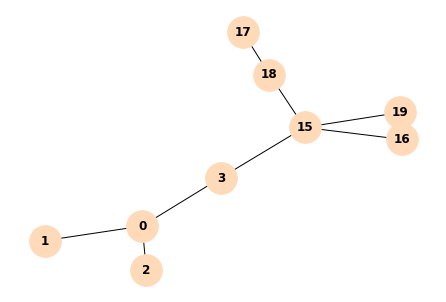

In [57]:
res = np.array([0, 1, 2, 3, 15, 16, 17, 18, 19])
k = nx.Graph(G.subgraph(res))
k.remove_edge(16, 17)
pos = nx.spring_layout(k)
nx.draw(k, pos, node_color="peachpuff", node_size=1000, with_labels=True, font_weight='bold', vmin=0, vmax=3)

In [15]:
nx.draw(k, pos, cmap=plt.get_cmap('tab10'), node_color=np.take(labels, res), edgecolors='black', node_size=1000, with_labels=True, font_weight='bold', vmin=0, vmax=3)

NameError: name 'k' is not defined

## Mask transformation

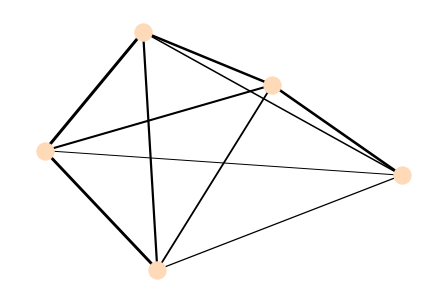

In [41]:
# Set up weighted adjacency matrix
A = np.array([[0, 0.2, 0.4, 0.8, 0.55],
              [0.2, 0, 0.7, 0.1, 0.3],
              [0.4, 0.7, 0, 0.5, 0.65],
             [0.8, 0.1, 0.5, 0, 0.85],
             [0.55, 0.3, 0.65, 0.85, 0]])

# Create DiGraph from A
G = nx.from_numpy_matrix(A, create_using=nx.Graph)

# Use spring_layout to handle positioning of graph
layout = nx.spring_layout(G)#, k=0.15, iterations=20)
# Get weights of each edge and assign to labels
edges, weights = zip(*nx.get_edge_attributes(G, "weight").items())

# Draw the graph using the layout - with_labels=True if you want node labels.
#nx.draw(G, layout, node_color="peachpuff", node_size=1000, with_labels=True, font_weight='bold', edgelist=edges, edge_color=weights,
            #width=5,
            #edge_cmap=plt.cm.Blues, edge_vmin=0, edge_vmax=1)
weights = np.array(weights)
weights = np.interp(weights, (weights.min(), weights.max()), (1, 3))
nx.draw(G, layout, node_color="peachpuff", edgelist=edges, width=weights)


### Sparsity

In [19]:
sparsity = 0.6
mask_len = A.shape[0]
mask_len

5

In [25]:
edge_index, mask = from_adj_to_edge_index(A)
mask

tensor([0.2000, 0.4000, 0.8000, 0.5500, 0.2000, 0.7000, 0.1000, 0.3000, 0.4000,
        0.7000, 0.5000, 0.6500, 0.8000, 0.1000, 0.5000, 0.8500, 0.5500, 0.3000,
        0.6500, 0.8500], dtype=torch.float64)

In [26]:
split_point = int((1 - sparsity) * mask_len)
unimportant_indices = (-mask).argsort()[split_point:]
mask[unimportant_indices] = 0

In [29]:
A_sparsity = from_edge_index_to_adj(edge_index, mask, mask_len)
A_sparsity = np.array(A_sparsity, dtype = np.float32)

In [41]:
A_sparsity

array([[0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.85],
       [0.  , 0.  , 0.  , 0.85, 0.  ]], dtype=float32)

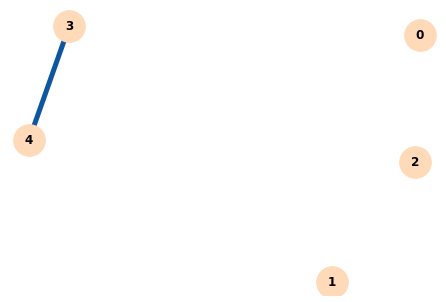

In [36]:
# Create DiGraph from A
G = nx.from_numpy_matrix(A_sparsity, create_using=nx.Graph)

# Use spring_layout to handle positioning of graph
#layout = nx.spring_layout(G)
# Get weights of each edge and assign to labels
edges, weights = zip(*nx.get_edge_attributes(G, "weight").items())

# Draw the graph using the layout - with_labels=True if you want node labels.
nx.draw(G, layout, node_color="peachpuff", node_size=1000, with_labels=True, font_weight='bold', edgelist=edges, edge_color=weights,
            width=5,
            edge_cmap=plt.cm.Blues, edge_vmin=0, edge_vmax=1)

### Threshold

In [38]:
threshold = 0.5
A_threshold = np.where(A > threshold, A, 0)

In [39]:
A_threshold

array([[0.  , 0.  , 0.  , 0.8 , 0.55],
       [0.  , 0.  , 0.7 , 0.  , 0.  ],
       [0.  , 0.7 , 0.  , 0.  , 0.65],
       [0.8 , 0.  , 0.  , 0.  , 0.85],
       [0.55, 0.  , 0.65, 0.85, 0.  ]])

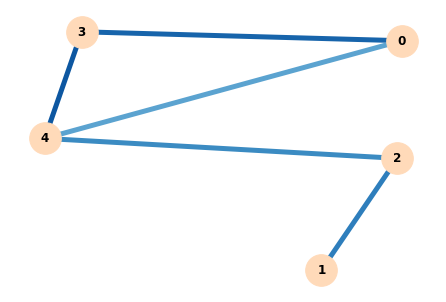

In [40]:
# Create DiGraph from A
G = nx.from_numpy_matrix(A_threshold, create_using=nx.Graph)

# Use spring_layout to handle positioning of graph
#layout = nx.spring_layout(G)
# Get weights of each edge and assign to labels
edges, weights = zip(*nx.get_edge_attributes(G, "weight").items())

# Draw the graph using the layout - with_labels=True if you want node labels.
nx.draw(G, layout, node_color="peachpuff", node_size=1000, with_labels=True, font_weight='bold', edgelist=edges, edge_color=weights,
            width=5,
            edge_cmap=plt.cm.Blues, edge_vmin=0, edge_vmax=1)

### TopK

In [69]:
k = 3

In [70]:
edge_index, mask = from_adj_to_edge_index(A)
mask

tensor([0.2000, 0.4000, 0.8000, 0.5500, 0.2000, 0.7000, 0.1000, 0.3000, 0.4000,
        0.7000, 0.5000, 0.6500, 0.8000, 0.1000, 0.5000, 0.8500, 0.5500, 0.3000,
        0.6500, 0.8500], dtype=torch.float64)

In [71]:
mask = mask_to_shape(mask, edge_index, k)
mask = torch.FloatTensor(mask)

In [72]:
edge_index

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4],
        [1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 0, 1, 2, 3]])

In [73]:
#unimportant_indices = (-mask).argsort()[k :]
#mask[unimportant_indices] = 0
A_topk = from_edge_index_to_adj(edge_index, mask, mask_len)
A_topk = np.array(A_topk, dtype = np.float32)

In [78]:
A_topk = np.array([[0., 0., 0., 0.8, 0.],
       [0., 0., 0.7, 0., 0.],
       [0., 0.7, 0., 0., 0.],
       [0.8, 0., 0., 0., 0.85],
       [0., 0., 0., 0.85, 0.]], dtype=np.float32)

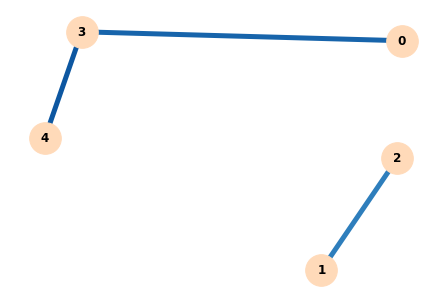

In [79]:
# Create DiGraph from A
G = nx.from_numpy_matrix(A_topk, create_using=nx.Graph)

# Use spring_layout to handle positioning of graph
#layout = nx.spring_layout(G)
# Get weights of each edge and assign to labels
edges, weights = zip(*nx.get_edge_attributes(G, "weight").items())

# Draw the graph using the layout - with_labels=True if you want node labels.
nx.draw(G, layout, node_color="peachpuff", node_size=1000, with_labels=True, font_weight='bold', edgelist=edges, edge_color=weights,
            width=5,
            edge_cmap=plt.cm.Blues, edge_vmin=0, edge_vmax=1)

In [ ]:
### Threshold

threshold = 0.5
A_threshold = np.where(A > threshold, A, 0)

A_threshold

# Create DiGraph from A
G = nx.from_numpy_matrix(A_threshold, create_using=nx.Graph)

# Use spring_layout to handle positioning of graph
#layout = nx.spring_layout(G)
# Get weights of each edge and assign to labels
edges, weights = zip(*nx.get_edge_attributes(G, "weight").items())

# Draw the graph using the layout - with_labels=True if you want node labels.
nx.draw(G, layout, node_color="peachpuff", node_size=1000, with_labels=True, font_weight='bold', edgelist=edges, edge_color=weights,
            width=5,
            edge_cmap=plt.cm.Blues, edge_vmin=0, edge_vmax=1)